# Bootstrapping to estimate parameter ranges of nonlinear models

When we first introduced ourselves to regression, we focused the regression algorithm’s ability to find the “truth”, i.e. how close to the true parameter values does the algorithm get.

In statistics and boostrapping, the truth is (typically) unknown and there is noise associated with any given measurement. So our question becomes “how confident am I that the parameters of my model are not zero?” And as discussed in class, all kinds of challenges arise when using bootstrapping. Here, we'll try a simple example.

Let's consider one of our equations for bacterial growth:
\begin{align}
\dot{y} = \frac{y^3}{a+y^3}-by
\end{align}

where y is the concentration of bacterium and a and b are parameters that help define the rate of bacterial growth and loss, respectively. 

You have been provided with data, called "Homework11 Data.csv". Use this data for the following excercises. In this file, you'll find the time points sampled and the concentration of bacterium (y) for 5 independent experiments. We will consider data to be independent across time and experiments.

## Part 1: Plot data and perform initial fitting

In the space below, load the data and write the code to fit the parameters of our model to the data using minimize or fsolve. You may want to revisit your previous homeworks. To make things a little easier, I'll give you the first guess for your parameter. Go with (a,b) = (0.3,0.8). After fitting:
   - clearly indicate what were the parameter values and the value of the cost function you implemented.
   - Plot on one plot the data and the fitted model's response

[[10.    6.2   4.07  8.13  7.97  7.07]
 [20.    8.84  5.63 10.9  10.9   9.8 ]
 [30.    9.99  9.16 11.    8.8  10.3 ]
 [50.   10.8  11.7  10.4  10.6   8.65]]
0.15389374110083404
      fun: 0.15389373961051767
 hess_inv: array([[5.95950437e-06, 2.18546821e-05],
       [2.18546821e-05, 8.04219520e-05]])
      jac: array([-2.04890966e-07,  1.98818743e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 215
      nit: 28
     njev: 68
   status: 2
  success: False
        x: array([-21.03536808,   0.09776889])


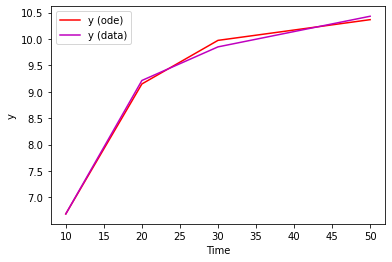

In [59]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint 
from scipy.optimize import minimize

#define constants


#load data using pandas
dat = pd.read_csv('Homework 6 Data.csv', header=0)

array = dat.values
print(array)

t = array[:,0]

#break apart data into sets for each experiment
Exp1 = array[:,1]
Exp2 = array[:,2]
Exp3 = array[:,3]
Exp4 = array[:,4]
Exp5 = array[:,5]

#Get averages from experiments at each time point
Avg1 = (Exp1[0] + Exp2[0] + Exp3[0] + Exp4[0] + Exp5[0])/5
Avg2 = (Exp1[1] + Exp2[1] + Exp3[1] + Exp4[1] + Exp5[1])/5
Avg3 = (Exp1[2] + Exp2[2] + Exp3[2] + Exp4[2] + Exp5[2])/5
Avg4 = (Exp1[3] + Exp2[3] + Exp3[3] + Exp4[3] + Exp5[3])/5

#Combine average data into an array
training_data = np.array([[Avg1],[Avg2],[Avg3],[Avg4]])
# Combo = np.array([Exp1,Exp2,Exp3,Exp4,Exp5])

#function for the ode
def odes(v,t,a,b):
    
    y = v[0]
 
    f = [(y**3/(a+y**3)) - b*y]
    return f

ic_3 = [Avg1]

#function to solve for RMSE
def RMSE(params):
    a,b = params;
    ODE_output = odeint(odes, ic_3, t, args = (a,b));
    err = training_data - ODE_output
    return np.sqrt(np.sum(err**2))

print(RMSE([-21.035,0.097769]))

#minimize to estimate parameters with initial guess
sol = minimize(RMSE, x0 = (0.3, 0.8));
print(sol);

#solve the ode at the estimated parameters
odesol = odeint(odes, ic_3, t, args = (-21.03536808,0.09776889))

#plot of data for y vs fitted ODE's of y
plt.plot(t, odesol, color = 'r')
plt.plot(t, training_data, color = 'm')
plt.xlabel("Time")
plt.ylabel("y")
plt.legend(['y (ode)', 'y (data)'])

## Part 2: Use sampling with replacement to create distributions of parameters that fit the data

Our hypothesis is that both a and b are greater than 0. Use the bootstrap method to create distributions of estimates of our parameter values. We can do this by, **for each iteration:**
   - Resample the data at each time point using sample with replacement (search online how to do).
   - Use minimize to refit the model to the resampled data
   - Save the fitted parameter estimates and the value of the cost function.
   
Do this for at least 200 iterations. HINT: this code may take a long time to run. It would be best to get the code working with only a few iterations. And once happy, then try 200. After completing, plot histograms of the fitted parameter values and cost function values. Figures must be clearly labeled and obvious to read. 

Based on these data, what is the p value for the null hypothesis that a and b are equal to zero? Calculate the one sided p value, based on the idea that we expect them to be greater than zero.
   

In [15]:
from sklearn.utils import resample

#break up data into each time point
datanot = array[:,1:5]

y10 = datanot[0,:]
y20 = datanot[1,:]
y30 = datanot[2,:]
y50 = datanot[3,:]

#for loop for resampling the data for 200 iterations
n=0
RMSEvals = []
avals = []
bvals = []
for n in range(200):
    
    #resample data at each time point
    y10new = resample(y10, n_samples=5, replace=True)
    y20new = resample(y20, n_samples=5, replace=True)
    y30new = resample(y30, n_samples=5, replace=True)
    y50new = resample(y50, n_samples=5, replace=True)
    
    #average resampled data
    y10avg = np.average(y10new)
    y20avg = np.average(y20new)
    y30avg = np.average(y30new)
    y50avg = np.average(y50new)
    
    #combine averages into array
    training_data = np.array([[y10avg],[y20avg],[y30avg],[y50avg]])

    ic_3 = [y10avg]
    
    #solve for RMSE and minimize parameters
    def RMSE(params):
        a,b = params;
        ODE_output = odeint(odes, ic_3, t, args = (a,b));
        err = training_data - ODE_output
        return np.sqrt(np.sum(err**2))

    sol = minimize(RMSE, x0 = (0.3, 0.8));
    
    #pull a, b, RMSE values into separate arrays for each iteration
    avals.append(sol.x[0])
    bvals.append(sol.x[1])
    RMSEvals.append(RMSE([avals[n],bvals[n]]))

[3.0, 2.0, 1.0, 3.0, 4.0, 1.0, 10.0, 9.0, 11.0, 15.0, 12.0, 13.0, 29.0, 20.0, 15.0, 9.0, 11.0, 8.0, 8.0, 4.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


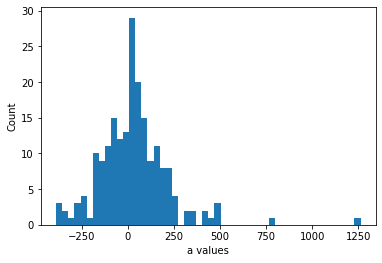

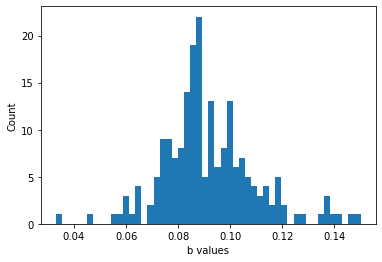

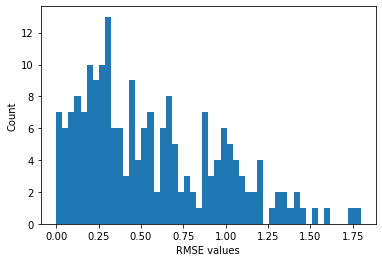

The P value for the null hypothesis that a and b = 0 is 0.03
The P value for the hypothesis that a and b > 0 is 0.82


In [55]:
import matplotlib.pyplot as plt

#plot histogram for parameters and RMSE values
plt.hist(avals, bins = 50)
plt.xlabel('a values')
plt.ylabel('Count')
#get histogram height at each a val
ax = plt.gca()
p = ax.patches
Counta = [patch.get_height() for patch in p]
print(Counta)
plt.show()

plt.hist(bvals, bins = 50)
plt.xlabel('b values')
plt.ylabel('Count')
ax = plt.gca()
p = ax.patches
Countb = [patch.get_height() for patch in p]
plt.show()

plt.hist(RMSEvals, bins = 50)
plt.xlabel('RMSE values')
plt.ylabel('Count')
ax = plt.gca()
p = ax.patches
CountRMSE = [patch.get_height() for patch in p]
plt.show()

#From plots can caculate the Pval for both a and b being equal to 0 and greater than 0
Pval0 = (13+0)/(np.sum(Counta)+np.sum(Countb))
Pvalover0 = (np.sum(Counta[11:50])+np.sum(Countb))/(np.sum(Counta)+np.sum(Countb))

print(f'The P value for the null hypothesis that a and b = 0 is {Pval0:0.2f}')
print(f'The P value for the hypothesis that a and b > 0 is {Pvalover0:0.2f}')

## Part 3 Analyze fit results

One a single figure, plot the model's response vs time for all 200 estimates of the parameter values. Are the fits reasonable? Should any of the fits be discounted? Why so? Does this change how you define your p values above? **Defend your answer here and include any plots as necessary:**



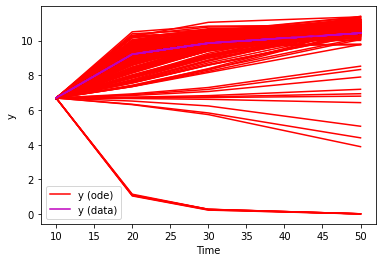

In [58]:
#set training data and ic back to origional values
training_data = np.array([[Avg1],[Avg2],[Avg3],[Avg4]])
ic_3 = [Avg1]

#for loop to plot model's response vs time for each 200 estimates of parameters
odesolvals = []
n = 0
for n in range(200):
    odesol = odeint(odes, ic_3, t, args = (avals[n],bvals[n]))
    odesolvals.append(odesol)
    plt.plot(t, odesol, color = 'r')
    plt.plot(t, training_data, color = 'm')
    plt.xlabel("Time")
    plt.ylabel("y")
    plt.legend(['y (ode)', 'y (data)'])
plt.show()

The majority of the fits seem reasonable although there are some fits that are off and then also some that are really off as can be seen by the plot above. The few fits that havea a very negative slope should be discounted. It seems these plots are fits of the data that are mirrored which for some reason the minimize function converged to. We know from the dataset we gathered that the concentration on average at least should be increasing and not decreasing to 0. If we were to discard these plots, it would slighly decrease the overall p value if both of the a and b derived from minimize are positive. If one of them is negative, then it will have no effect.

## Project Data Description
The measument I am planning to analyze is covid case count per county and the two factors are population density and GINI index per country.